# Hacettepe University
### BBM 409 2st ASSIGNMENT


#### Name and Surname: Fatih Pehlivan – Göktuğ Ocaklıoğlu
#### Identity Number: 21946529 - 2200356841
#### Course:  BBM 409

#### Advisor: Burçak Asal

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

Define a class of decision tree

In [2]:
class Node:

    def __init__(self):
        self.gain = 0
        self.value = ""
        self.children = []
        self.isLeaf = False
        self.predict = ""
        self.numberofYes = 0
        self.numberofNo = 0
        self.parent = None

    def insertChild(self, value):
        value.parent = self
        self.children.append(value)

    def printTree(root, depth=0):
        print()
        print("\t" * depth, end="")
        print("{}  [YES]={} [NO]={}".format(root.value, root.numberofYes, root.numberofNo), end="")
        if root.isLeaf:
            print(" -> ", root.predict)
        else:
            for child in root.children:
                child.printTree(depth + 1)

    def findLeaves(root, leafList):
        if root.isLeaf:
            return
        allChild = False
        for child in root.children:
            if child.isLeaf:
                allChild = True
            else:
                allChild = False
                break
        if allChild:
            leafList.append(root)
        for child in root.children:
                child.findLeaves(leafList)

    def __lt__(self, other):
        return self.gain < other.gain

In [3]:
#Calculates total data entropy
def cal_total_data_entropy(output_values):
    output_unique, counts_elements = np.unique(output_values,return_counts=True)
    entropy = 0
    for count in counts_elements:
        prob = count/sum(counts_elements)
        entropy -= prob * math.log2(prob)
    return entropy

In [4]:
#Calculates entropy of a feature
def cal_attribute_entropy(attribute_values, output_values):
    attribute_unique_values = np.unique(attribute_values)
    output_unique_values = np.unique(output_values)
    data_set=np.column_stack((attribute_values,output_values))
    total_entropy = 0
    for i in attribute_unique_values:
        sub1=data_set[np.where(data_set[:,0]==i)]
        entropy = 0
        for j in output_unique_values:
            sub2=sub1[np.where(sub1[:,1]==j)]
            prob = np.size(sub2,axis=0)/np.size(sub1,axis=0)
            if prob!=0:
                entropy -= prob * math.log2(prob)
        total_entropy += np.size(sub1,axis=0)/np.size(data_set,axis=0) * entropy
    return total_entropy

In [5]:
#Calculates gain of a feature
def cal_gain(train_attribute_data, train_output_data):
    return cal_total_data_entropy(train_output_data)-cal_attribute_entropy(train_attribute_data,train_output_data)

In [6]:
#Finds the most gain feature from the current dataset
def find_most_gain_attribute(X_train, Y_train):
    max_gain = 0
    attribute_name = ""
    for attribute in X_train.columns:
        attribute_value=X_train[attribute].values
        attribute_gain=cal_gain(attribute_value,Y_train)

        if attribute_gain>max_gain:
            max_gain = attribute_gain
            attribute_name = attribute
    return  attribute_name

In [7]:
#Discretize continues variable
def discretization(train_attribute_values, test_attribute_values, attribute_name):
    # Find first quartile, second quartile and third quartile of attribute values
    Q1 = np.percentile(train_attribute_values, 25)
    Q2 = np.percentile(train_attribute_values, 50)
    Q3 = np.percentile(train_attribute_values, 75)

    # train attribute value < Q1
    index1 = np.where(train_attribute_values <= Q1)
    index2 = np.where((train_attribute_values > Q1) & (train_attribute_values <= Q2))
    index3 = np.where((train_attribute_values > Q2) & (train_attribute_values <= Q3))
    index4 = np.where(train_attribute_values > Q3)

    # test attribute value index for restricted area
    test_index1 = np.where(test_attribute_values <= Q1)
    test_index2 = np.where((test_attribute_values > Q1) & (test_attribute_values <= Q2))
    test_index3 = np.where((test_attribute_values > Q2) & (test_attribute_values <= Q3))
    test_index4 = np.where(test_attribute_values > Q3)

    test_attribute_values = test_attribute_values.astype("<U50")
    train_attribute_values = train_attribute_values.astype("<U50")

    for i, j, k, l in zip(index1, index2, index3, index4):
        train_attribute_values[i] = "{}<={}".format(attribute_name, Q1)
        train_attribute_values[j] = "{}<{}<={}".format(Q1, attribute_name, Q2)
        train_attribute_values[k] = "{}<{}<={}".format(Q2, attribute_name, Q3)
        train_attribute_values[l] = "{}<{}".format(Q3, attribute_name)

    for i, j, k, l in zip(test_index1, test_index2, test_index3, test_index4):
        test_attribute_values[i] = "{}<={}".format(attribute_name, Q1)
        test_attribute_values[j] = "{}<{}<={}".format(Q1, attribute_name, Q2)
        test_attribute_values[k] = "{}<{}<={}".format(Q2, attribute_name, Q3)
        test_attribute_values[l] = "{}<{}".format(Q3, attribute_name)

    return train_attribute_values, test_attribute_values

In [8]:
#Read csv file
data=pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [9]:
#Shuffle data
data=data.sample(frac=1)
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1251,30,No,Travel_Rarely,979,Sales,15,2,Marketing,1,1754,...,1,80,1,12,2,3,7,7,1,7
1411,25,No,Travel_Rarely,309,Human Resources,2,3,Human Resources,1,1987,...,3,80,0,6,3,3,2,0,1,2
1310,58,No,Travel_Frequently,1216,Research & Development,15,4,Life Sciences,1,1837,...,2,80,0,23,3,3,2,2,2,2
418,26,No,Travel_Rarely,1349,Research & Development,23,3,Life Sciences,1,560,...,2,80,2,3,3,1,3,2,0,2
499,33,No,Travel_Rarely,1216,Sales,8,4,Marketing,1,677,...,4,80,0,6,3,3,5,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,46,No,Travel_Rarely,717,Research & Development,13,4,Life Sciences,1,1727,...,4,80,0,19,3,3,10,7,0,9
179,38,No,Travel_Rarely,1380,Research & Development,9,2,Life Sciences,1,245,...,3,80,0,2,3,3,2,2,2,1
355,26,No,Travel_Rarely,933,Sales,1,3,Life Sciences,1,476,...,2,80,1,8,3,3,8,7,7,7
378,34,Yes,Non-Travel,1362,Sales,19,3,Marketing,1,502,...,2,80,0,9,3,2,5,2,0,4


In [10]:
X_train,X_test=train_test_split(data, train_size=0.8,shuffle=False)

In [11]:
X_train

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1251,30,No,Travel_Rarely,979,Sales,15,2,Marketing,1,1754,...,1,80,1,12,2,3,7,7,1,7
1411,25,No,Travel_Rarely,309,Human Resources,2,3,Human Resources,1,1987,...,3,80,0,6,3,3,2,0,1,2
1310,58,No,Travel_Frequently,1216,Research & Development,15,4,Life Sciences,1,1837,...,2,80,0,23,3,3,2,2,2,2
418,26,No,Travel_Rarely,1349,Research & Development,23,3,Life Sciences,1,560,...,2,80,2,3,3,1,3,2,0,2
499,33,No,Travel_Rarely,1216,Sales,8,4,Marketing,1,677,...,4,80,0,6,3,3,5,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,27,No,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1,1244,...,4,80,2,9,3,2,9,7,6,8
1287,42,No,Travel_Rarely,1128,Research & Development,13,3,Medical,1,1803,...,3,80,2,10,2,2,0,0,0,0
1196,41,No,Travel_Rarely,1206,Sales,23,2,Life Sciences,1,1678,...,4,80,0,21,2,3,2,0,0,2
1126,50,No,Travel_Rarely,264,Sales,9,3,Marketing,1,1591,...,3,80,1,27,2,3,1,0,0,0


In [12]:
X_test

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1450,35,No,Travel_Rarely,1146,Human Resources,26,4,Life Sciences,1,2040,...,3,80,0,9,2,3,9,0,1,7
1462,39,No,Travel_Rarely,722,Sales,24,1,Marketing,1,2056,...,1,80,1,21,2,2,20,9,9,6
903,29,No,Travel_Rarely,1329,Research & Development,7,3,Life Sciences,1,1260,...,2,80,2,6,2,3,6,0,1,0
1157,35,No,Non-Travel,208,Research & Development,8,4,Life Sciences,1,1630,...,4,80,1,15,5,3,14,11,2,9
1234,47,No,Non-Travel,543,Sales,2,4,Marketing,1,1731,...,4,80,1,4,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,46,No,Travel_Rarely,717,Research & Development,13,4,Life Sciences,1,1727,...,4,80,0,19,3,3,10,7,0,9
179,38,No,Travel_Rarely,1380,Research & Development,9,2,Life Sciences,1,245,...,3,80,0,2,3,3,2,2,2,1
355,26,No,Travel_Rarely,933,Sales,1,3,Life Sciences,1,476,...,2,80,1,8,3,3,8,7,7,7
378,34,Yes,Non-Travel,1362,Sales,19,3,Marketing,1,502,...,2,80,0,9,3,2,5,2,0,4


In [13]:
#output test and train data
Y_train = X_train["Attrition"]
X_train = X_train.drop("Attrition",axis=1)
Y_test = X_test["Attrition"]
X_test = X_test.drop("Attrition",axis=1)

# Tree Part

In [14]:
#Generates decision tree
def generate_Tree(X_train, Y_train):
    #create new Node
    root = Node()
    #find max gain attribute
    max_feature=find_most_gain_attribute(X_train,Y_train)
    #find unique attribute values
    output_label, output_count = np.unique(Y_train,return_counts=True)
    #feature name is root value
    root.value=max_feature
    root.gain=cal_gain(X_train[max_feature],Y_train)
    for i,j in zip(output_label, output_count):
        if i=="Yes":
            root.numberofYes = j
        else:
            root.numberofNo=j

    #branc of root are unique values of feature
    unique_val, counts = np.unique(X_train[max_feature], return_counts=True)

    for label, count in zip(unique_val,counts):
        index = X_train[max_feature]==label
        X_train_sub=X_train[index]
        Y_train_sub=Y_train[index]

        output_label, output_count = np.unique(Y_train_sub,return_counts=True)

        # If attribute entropy is 0, this label is pure node
        if cal_attribute_entropy(X_train_sub[max_feature],Y_train_sub)==0:
            leafNode = Node()
            leafNode.value=label
            for i,j in zip(output_label, output_count):
                if i=="Yes":
                    leafNode.numberofYes = j
                else:
                    leafNode.numberofNo=j
            leafNode.isLeaf=True
            leafNode.predict = Y_train_sub.values[0]
            root.insertChild(leafNode)

        #If attribute entropy is not 0, this label is new root.
        else:
            newRoot = Node()
            newRoot.value=label
            for i,j in zip(output_label, output_count):
                if i=="Yes":
                    newRoot.numberofYes = j
                else:
                    newRoot.numberofNo = j
            X_train_sub_copy = X_train_sub.drop(max_feature,axis=1)
            #Find child root recursively
            child = generate_Tree(X_train_sub_copy,Y_train_sub)
            newRoot.insertChild(child)
            root.insertChild(newRoot)
    return root

In [15]:
#Predict output of a sample based on decision tree model
def predict(root, sample):
    for child in root.children:
        if child.value == sample[root.value]:
            if child.isLeaf:
                return child.predict
            else:
                return predict (child.children[0], sample)
    if root.numberofYes > root.numberofNo:
        return "Yes"
    else:
        return "No"


validation 1


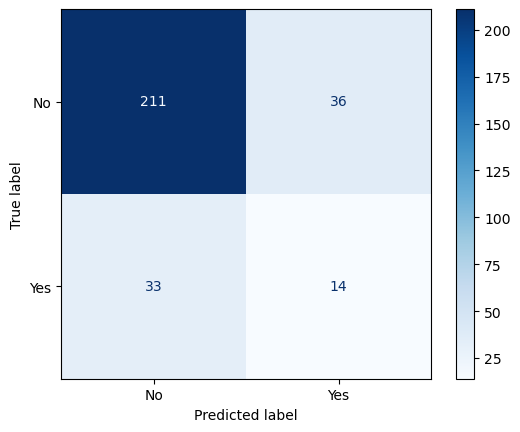

accuracy:  0.7653061224489796
precision:  0.28
recall:  0.2978723404255319
f1_score:  0.288659793814433

validation 2


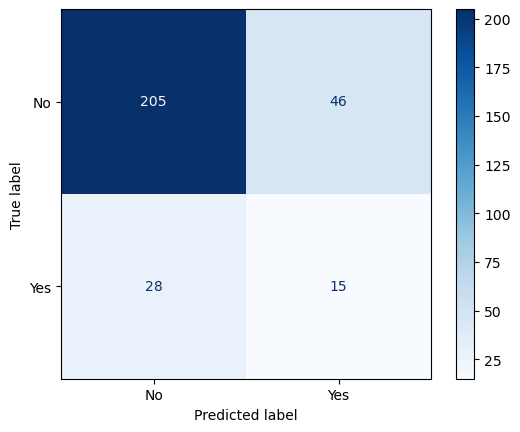

accuracy:  0.7482993197278912
precision:  0.2459016393442623
recall:  0.3488372093023256
f1_score:  0.28846153846153844

validation 3


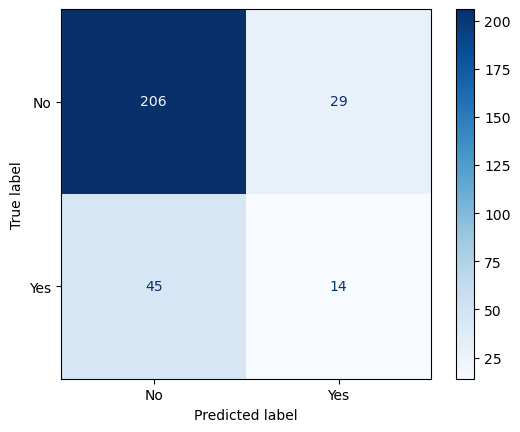

accuracy:  0.7482993197278912
precision:  0.32558139534883723
recall:  0.23728813559322035
f1_score:  0.2745098039215686

validation 4


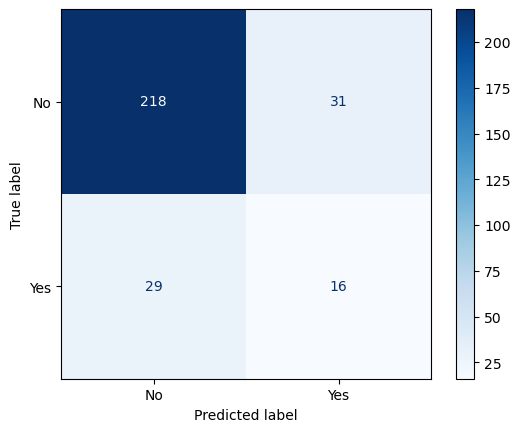

accuracy:  0.7959183673469388
precision:  0.3404255319148936
recall:  0.35555555555555557
f1_score:  0.3478260869565218

validation 5


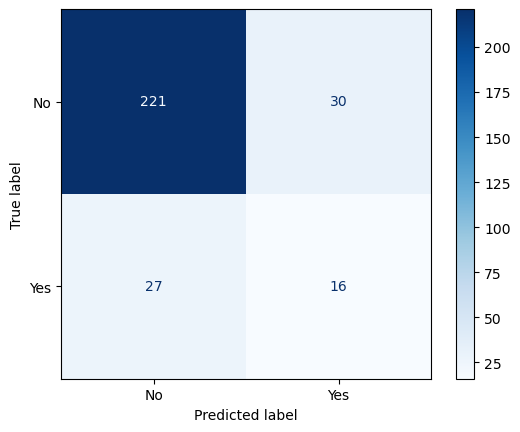

accuracy:  0.8061224489795918
precision:  0.34782608695652173
recall:  0.37209302325581395
f1_score:  0.35955056179775285


In [16]:
kf = KFold(n_splits=5)
validation=0
array_root=[]
mis_X=[]
mis_Y=[]
for train_index, test_index in kf.split(data):
    X_train = data.loc[train_index]
    X_test = data.loc[test_index]
    #Discretization process
    for attribution in X_train.columns:
        if X_train[attribution].dtype=="int64":
            X_train[attribution], X_test[attribution] = discretization(X_train[attribution].values,X_test[attribution].values, attribution)
    #output test and train data
    Y_train = X_train["Attrition"]
    X_train = X_train.drop("Attrition",axis=1)
    Y_test = X_test["Attrition"]
    X_test = X_test.drop("Attrition",axis=1)

    #generates tree
    root=generate_Tree(X_train,Y_train)

    array_root.append(root)

    #predict test values
    predict_array=[]
    for i in range(X_test.shape[0]):
        sample = X_test.iloc[i]
        predict_array.append(predict(root,sample))

    #Find some misclassified sample
    mis_index=np.where(Y_test!=predict_array)
    mis_index=np.random.choice(mis_index[0],3)
    mis_X.append(X_test.iloc[mis_index])
    mis_Y.append(Y_test.iloc[mis_index])

    validation+=1
    print("\nvalidation",validation)
    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=predict_array)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["No", "Yes"])
    cm_display.plot(cmap=plt.cm.get_cmap("Blues"))
    plt.show()

    print("accuracy: " ,accuracy_score(Y_test, predict_array))
    print("precision: ", precision_score(Y_test,predict_array, pos_label="Yes"))
    print("recall: ",recall_score(Y_test,predict_array,pos_label="Yes"))
    print("f1_score: ", f1_score(Y_test,predict_array,pos_label="Yes"))

When we look at the accuracy, precision, recall and f1 scores, we see that the best result is 5th. 5th decision tree model has the best result, so we choose 5th decision tree model

In [17]:
#print best decision tree model (5th)
root=array_root[4]
root.printTree()


JobRole  [YES]=194 [NO]=982
	Healthcare Representative  [YES]=8 [NO]=93
		PercentSalaryHike  [YES]=8 [NO]=93
			12.0<PercentSalaryHike<=14.0  [YES]=0 [NO]=29 ->  No

			14.0<PercentSalaryHike<=18.0  [YES]=1 [NO]=20
				HourlyRate  [YES]=1 [NO]=20
					48.0<HourlyRate<=66.0  [YES]=1 [NO]=3
						DailyRate  [YES]=1 [NO]=3
							469.0<DailyRate<=806.5  [YES]=0 [NO]=2 ->  No

							806.5<DailyRate<=1157.0  [YES]=1 [NO]=0 ->  Yes

							DailyRate<=469.0  [YES]=0 [NO]=1 ->  No

					66.0<HourlyRate<=83.0  [YES]=0 [NO]=4 ->  No

					83.0<HourlyRate  [YES]=0 [NO]=4 ->  No

					HourlyRate<=48.0  [YES]=0 [NO]=9 ->  No

			18.0<PercentSalaryHike  [YES]=1 [NO]=22
				OverTime  [YES]=1 [NO]=22
					No  [YES]=0 [NO]=21 ->  No

					Yes  [YES]=1 [NO]=1
						Age  [YES]=1 [NO]=1
							30.0<Age<=36.0  [YES]=0 [NO]=1 ->  No

							36.0<Age<=43.0  [YES]=1 [NO]=0 ->  Yes

			PercentSalaryHike<=12.0  [YES]=6 [NO]=22
				JobLevel  [YES]=6 [NO]=22
					1.0<JobLevel<=2.0  [YES]=0 [NO]=13 ->  No

					

## Error Analysis for Classification

In [30]:
#Some misclassified sample
pd.DataFrame(mis_X[4])

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1422,30.0<Age<=36.0,Travel_Rarely,1157.0<DailyRate,Research & Development,7.0<DistanceFromHome<=14.0,3.0<Education<=4.0,Medical,EmployeeCount<=1.0,1235.5<EmployeeNumber,3.0<EnvironmentSatisfaction<=4.0,...,2.0<RelationshipSatisfaction<=3.0,StandardHours<=80.0,0.0<StockOptionLevel<=1.0,TotalWorkingYears<=6.0,2.0<TrainingTimesLastYear<=3.0,2.0<WorkLifeBalance<=3.0,YearsAtCompany<=3.0,YearsInCurrentRole<=2.0,1.0<YearsSinceLastPromotion<=3.0,YearsWithCurrManager<=2.0
1355,30.0<Age<=36.0,Travel_Rarely,DailyRate<=469.0,Sales,14.0<DistanceFromHome,Education<=2.0,Marketing,EmployeeCount<=1.0,1235.5<EmployeeNumber,2.0<EnvironmentSatisfaction<=3.0,...,2.0<RelationshipSatisfaction<=3.0,StandardHours<=80.0,1.0<StockOptionLevel,10.0<TotalWorkingYears<=16.0,TrainingTimesLastYear<=2.0,WorkLifeBalance<=2.0,3.0<YearsAtCompany<=5.0,YearsInCurrentRole<=2.0,0.0<YearsSinceLastPromotion<=1.0,2.0<YearsWithCurrManager<=3.0
1293,36.0<Age<=43.0,Non-Travel,DailyRate<=469.0,Research & Development,7.0<DistanceFromHome<=14.0,2.0<Education<=3.0,Life Sciences,EmployeeCount<=1.0,1235.5<EmployeeNumber,EnvironmentSatisfaction<=2.0,...,2.0<RelationshipSatisfaction<=3.0,StandardHours<=80.0,StockOptionLevel<=0.0,6.0<TotalWorkingYears<=10.0,TrainingTimesLastYear<=2.0,WorkLifeBalance<=2.0,YearsAtCompany<=3.0,YearsInCurrentRole<=2.0,0.0<YearsSinceLastPromotion<=1.0,YearsWithCurrManager<=2.0


In [19]:
#Attrition of misclassified sample
pd.DataFrame(mis_Y[4])

,Attrition
1422,No
1355,No
1293,No


In [20]:
#output of misclassified sample based on decision tree
predict(root,mis_X[4].iloc[1])

'Yes'

We see that sample 1355 follows JobRole:Sales Executive -> StockOptionLevel: 1.0< StockOptionLevel-> DistanceFromHome: 14.0< DistanceFromHome -> NumCompaniesWorked:1.0<NumCompaniesWorked<=2.0 -> Yes  in the decision tree. But attrition of sample is No. That's why this sample is misclassified

If the sample does not have a leaf to go, the sample goes as deep as it can go and chooses the one with more yes and no values in the last root. This can cause misclassification.

# Part 2

In [21]:
#before prunning
X_train_p2, X_val, Y_train_p2, Y_val = train_test_split(X_train, Y_train, train_size=0.75, shuffle=True)

root_p2 = generate_Tree(X_train_p2, Y_train_p2)
root_p2.printTree()


OverTime  [YES]=146 [NO]=736
	No  [YES]=64 [NO]=566
		JobRole  [YES]=64 [NO]=566
			Healthcare Representative  [YES]=6 [NO]=49
				PercentSalaryHike  [YES]=6 [NO]=49
					12.0<PercentSalaryHike<=14.0  [YES]=0 [NO]=12 ->  No

					14.0<PercentSalaryHike<=18.0  [YES]=1 [NO]=8
						Education  [YES]=1 [NO]=8
							2.0<Education<=3.0  [YES]=0 [NO]=6 ->  No

							3.0<Education<=4.0  [YES]=0 [NO]=1 ->  No

							Education<=2.0  [YES]=1 [NO]=1
								DailyRate  [YES]=1 [NO]=1
									806.5<DailyRate<=1157.0  [YES]=1 [NO]=0 ->  Yes

									DailyRate<=469.0  [YES]=0 [NO]=1 ->  No

					18.0<PercentSalaryHike  [YES]=0 [NO]=18 ->  No

					PercentSalaryHike<=12.0  [YES]=5 [NO]=11
						DistanceFromHome  [YES]=5 [NO]=11
							14.0<DistanceFromHome  [YES]=4 [NO]=1
								DailyRate  [YES]=4 [NO]=1
									1157.0<DailyRate  [YES]=1 [NO]=0 ->  Yes

									469.0<DailyRate<=806.5  [YES]=2 [NO]=0 ->  Yes

									806.5<DailyRate<=1157.0  [YES]=0 [NO]=1 ->  No

									DailyRate<=469.0  [Y

Calculated first accuracy with test case before pruning.

In [22]:
predict_array = []
for i in range(X_test.shape[0]):
    sample = X_test.iloc[i]
    predict_array.append(predict(root_p2, sample))
first_acc = accuracy_score(Y_test, predict_array)


Calculeted current accuracy with validation test before pruning

In [23]:
def find_acc():
    predict_array = []
    for i in range(X_val.shape[0]):
        sample = X_val.iloc[i]
        predict_array.append(predict(root_p2, sample))
    return accuracy_score(Y_val, predict_array)
current_acc = find_acc()
current_acc

0.7517006802721088

Pruning starts
If removed element's number of Yes and number of No equals to each other, my prediction became No

In [24]:
find_leaves = []
root_p2.findLeaves(find_leaves)
removed_elements = []

while len(find_leaves) != 0:
    # Founded all twigs and sorted all twigs according to their Information Gain.
    find_leaves = []
    root_p2.findLeaves(find_leaves)
    find_leaves.sort()

    # Get the first element (less information gain) and pop it from the list
    leaf = find_leaves.pop()

    # By default, made our element to leaf and made prediction of the element = No
    leaf.isLeaf = True
    yes = leaf.numberofYes
    no = leaf.numberofNo
    leaf.predict = "No"

    # If number of yes greater than number of no
    if yes > no:
        leaf.predict = "Yes"
    # Calculated new accuracy with validation sets by using pruning tree
    new_acc = find_acc()

    # When new accuracy equal or greater than current accuracy, Prune transaction is running
    if new_acc >= current_acc:
        removed_elements.append(leaf)
        current_acc = new_acc

    # Else undo all transactions and terminate the loop
    else:
        leaf.predict = ""
        leaf.isLeaf = False
        break

In [25]:
# Print the pruned tree
root_p2.printTree()


OverTime  [YES]=146 [NO]=736
	No  [YES]=64 [NO]=566
		JobRole  [YES]=64 [NO]=566
			Healthcare Representative  [YES]=6 [NO]=49
				PercentSalaryHike  [YES]=6 [NO]=49
					12.0<PercentSalaryHike<=14.0  [YES]=0 [NO]=12 ->  No

					14.0<PercentSalaryHike<=18.0  [YES]=1 [NO]=8
						Education  [YES]=1 [NO]=8
							2.0<Education<=3.0  [YES]=0 [NO]=6 ->  No

							3.0<Education<=4.0  [YES]=0 [NO]=1 ->  No

							Education<=2.0  [YES]=1 [NO]=1
								DailyRate  [YES]=1 [NO]=1 ->  No

					18.0<PercentSalaryHike  [YES]=0 [NO]=18 ->  No

					PercentSalaryHike<=12.0  [YES]=5 [NO]=11
						DistanceFromHome  [YES]=5 [NO]=11
							14.0<DistanceFromHome  [YES]=4 [NO]=1
								DailyRate  [YES]=4 [NO]=1 ->  Yes

							2.0<DistanceFromHome<=7.0  [YES]=0 [NO]=3 ->  No

							7.0<DistanceFromHome<=14.0  [YES]=0 [NO]=4 ->  No

							DistanceFromHome<=2.0  [YES]=1 [NO]=3
								BusinessTravel  [YES]=1 [NO]=3 ->  No

			Human Resources  [YES]=2 [NO]=19
				TotalWorkingYears  [YES]=2 [NO]=19
			

In [26]:
# Print pruned elements
for i in removed_elements:
    i.isLeaf = False
    i.printTree()
    i.isLeaf = True


Age  [YES]=2 [NO]=2
	30.0<Age<=36.0  [YES]=1 [NO]=0 ->  Yes

	36.0<Age<=43.0  [YES]=1 [NO]=0 ->  Yes

	43.0<Age  [YES]=0 [NO]=1 ->  No

	Age<=30.0  [YES]=0 [NO]=1 ->  No

Education  [YES]=1 [NO]=1
	2.0<Education<=3.0  [YES]=1 [NO]=0 ->  Yes

	Education<=2.0  [YES]=0 [NO]=1 ->  No

Age  [YES]=1 [NO]=1
	30.0<Age<=36.0  [YES]=0 [NO]=1 ->  No

	43.0<Age  [YES]=1 [NO]=0 ->  Yes

Age  [YES]=2 [NO]=2
	30.0<Age<=36.0  [YES]=0 [NO]=1 ->  No

	36.0<Age<=43.0  [YES]=0 [NO]=1 ->  No

	Age<=30.0  [YES]=2 [NO]=0 ->  Yes

EmployeeNumber  [YES]=1 [NO]=1
	1235.5<EmployeeNumber  [YES]=1 [NO]=0 ->  Yes

	814.0<EmployeeNumber<=1235.5  [YES]=0 [NO]=1 ->  No

JobLevel  [YES]=2 [NO]=2
	1.0<JobLevel<=2.0  [YES]=0 [NO]=2 ->  No

	2.0<JobLevel<=3.0  [YES]=2 [NO]=0 ->  Yes

DailyRate  [YES]=2 [NO]=2
	469.0<DailyRate<=806.5  [YES]=0 [NO]=2 ->  No

	806.5<DailyRate<=1157.0  [YES]=2 [NO]=0 ->  Yes

Age  [YES]=1 [NO]=1
	36.0<Age<=43.0  [YES]=0 [NO]=1 ->  No

	Age<=30.0  [YES]=1 [NO]=0 ->  Yes

DailyRate  [YES]=1 [N

First tree is totally depend on train case. Train case error will be 0. However, it causes over-fitting problem. For every situation there is a branch and leaf. This may affect decrease when testing. Above results provide us less information gain than others. These twigs make the tree very specific.

These twigs generally:
Number of yes values and 0 (or a few) no value or
0 (or a few) yes values and number of no values.
So that their informaiton gains are less than others.

In [27]:
predict_array = []
for i in range(X_test.shape[0]):
    sample = X_test.iloc[i]
    predict_array.append(predict(root_p2, sample))
last_acc = accuracy_score(Y_test, predict_array)

In [28]:
first_acc

0.7789115646258503

In [29]:
last_acc

0.7857142857142857

Generally last_acc >= first_acc. Because first_acc is very depend on train set. With pruning, I created more general tree and this generally increase accuracy value.
However, somtimes first_acc > last_acc. If there are more samples in the data-set, our first tree is very very depend on training set. This situation appears less likely.